In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import pdftotext

df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):
    
    pdfFileObj = open("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Amazon/20%s_proxy.pdf"%(k),'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    
    year = "20%s"%(k)
    company = "Amazon"

    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for page in pdf:
        x = page.replace('\n \n',', ')
        x = page.replace('\n',' ')
        sub_df = sub_df.append({'raw_text':x,'year':year,'company':company},ignore_index=True)

    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(340, 3)

In [4]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x) 
                                                   if word not in stop_words and word not in punctuations])

In [5]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])


In [6]:
remove_words =['shareholders','board','mr.','director','committee','proxy','meeting','share','vote','shareholder','stock','plan','amazon']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [7]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [8]:
amazon_df = df[['year','company','tokens_final']]

amazon_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\amazon.csv', index = False)

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [11]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.026*"risk" + 0.019*"management" + 0.016*"harassment" + '
        '0.014*"policy" + 0.012*"fund" + 0.011*"relate" + 0.011*"review" + '
        '0.011*"invest" + 0.011*"leadership" + 0.010*"past"'),
    (   1,
        '0.041*"development" + 0.040*"leadership" + 0.020*"discussion" + '
        '0.019*"audit" + 0.016*"review" + 0.014*"analysis" + '
        '0.014*"management" + 0.014*"security" + 0.013*"program" + '
        '0.012*"information"'),
    (   2,
        '0.020*"unit" + 0.017*"restrict" + 0.013*"nominee" + 0.012*"award" + '
        '0.012*"proposal" + 0.009*"food" + 0.008*"serve" + '
        '0.008*"contribution" + 0.008*"equity" + 0.008*"state"'),
    (   3,
        '0.033*"material" + 0.023*"proposal" + 0.017*"internet" + 0.017*"hold" '
        '+ 0.017*"record" + 0.014*"entitle" + 0.013*"availability" + '
        '0.011*"date" + 0.011*"approval" + 0.010*"auditor"'),
    (   4,
        '0.017*"customer" + 0.016*"technology" + 0.012*"restrict" + '
        

In [12]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [13]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.116325 -0.015494       1        1  13.835077
9     -0.029813  0.133274       2        1  12.604305
10    -0.186784 -0.076970       3        1  11.292694
8      0.006073  0.055805       4        1   9.163436
14     0.108043 -0.025350       5        1   8.515462
5      0.022609  0.061377       6        1   8.175980
12     0.129152 -0.118507       7        1   5.610847
13     0.009553 -0.025732       8        1   5.504924
7     -0.114657  0.021722       9        1   5.496668
3      0.061594  0.184660      10        1   5.444812
1     -0.043660  0.031577      11        1   4.830966
2      0.032678 -0.072787      12        1   4.567594
4      0.035719 -0.078311      13        1   2.695633
6      0.001233 -0.036911      14        1   1.273953
0     -0.148065 -0.038354      15        1   0.987651, topic_info=             Term        Freq       Total Category  logprob  loglift
282         audit  428.000000  428.000000  Default  30.0000  30.0000
206        august  223.000000  223.000000  Default  29.0000  29.0000
451          unit  491.000000  491.000000  Default  28.0000  28.0000
449      restrict  329.000000  329.000000  Default  27.0000  27.0000
226    experience  324.000000  324.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
169   information    2.902250  258.107239  Topic15  -5.1052   0.1297
327  relationship    2.391956   62.125355  Topic15  -5.2986   1.3606
256     president    2.515348  185.114532  Topic15  -5.2483   0.3190
282         audit    2.645515  428.894836  Topic15  -5.1978  -0.4708
122          form    2.457213  150.175766  Topic15  -5.2717   0.5048

[1065 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
2280     14  0.500748               //www.aboutamazon.com/sustainability
1852     12  0.446649  //www.aboutamazon.com/sustainability/circular-...
2265     14  0.628176                         //www.amazon.com/diversity
545       2  0.310148                     //www.fec.gov/disclosure.shtml
545      12  0.310148                     //www.fec.gov/disclosure.shtml
...     ...       ...                                                ...
972      10  0.695811                                          —approval
200       2  0.104472                                          —election
200       6  0.731301                                          —election
455       6  0.532326                                      —ratification
455       8  0.212930                                      —ratification

[4355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 10, 11, 9, 15, 6, 13, 14, 8, 4, 2, 3, 5, 7, 1])

In [14]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [15]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,2010,"[notice, hold, amazon.com, hold, time, tuesday...",3.0,0.9836,"material, proposal, internet, hold, record, en..."
1,NaN,NaN,3.0,0.9920,"material, proposal, internet, hold, record, en..."
2,2010,"[statement, hold, tuesday, general, solicit, a...",9.0,0.8252,"governance, candidate, proposal, matter, instr..."
3,2010,"[meaning, individual, name, provide, authoriza...",5.0,0.5551,"person, date, hold, ownership, record, audit, ..."
4,2010,"[revocation, record, revoke, time, secretary, ...",10.0,0.9952,"experience, skill, serve, technology, presiden..."
5,2010,"[skill, background, oversight, company, qualif...",7.0,0.5523,"governance, leadership, risk, audit, developme..."
6,2010,"[executive, officer, president, co-chair, june...",7.0,0.9519,"governance, leadership, risk, audit, developme..."
7,2010,"[please, visit, company, investor, relation, w...",9.0,0.8496,"governance, candidate, proposal, matter, instr..."
8,2010,"[independence, performance, company, auditor, ...",5.0,0.6439,"person, date, hold, ownership, record, audit, ..."
9,2010,"[consider, candidate, recommendation, receive,...",13.0,0.8252,"audit, auditor, service, policy, management, c..."


In [16]:
df_dominant_topic.shape

(340, 5)

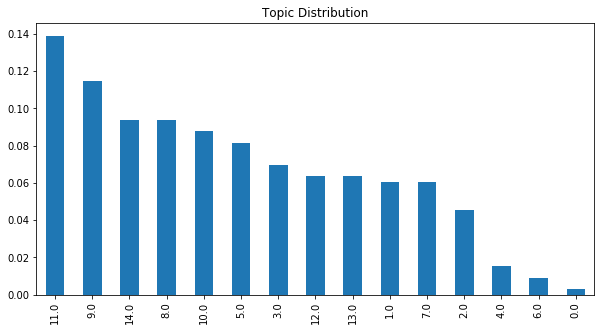

In [17]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [18]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [19]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.000000,0.000000,0.041667,0.083333,0.000000,0.125000,0.000000,0.083333,0.083333,0.166667,0.041667,0.166667,0.041667,0.083333,0.083333
2011,0.000000,0.148148,0.000000,0.074074,0.000000,0.111111,0.000000,0.037037,0.111111,0.111111,0.074074,0.111111,0.037037,0.111111,0.074074
2012,0.000000,0.100000,0.066667,0.066667,0.000000,0.100000,0.000000,0.066667,0.033333,0.100000,0.066667,0.200000,0.000000,0.066667,0.133333
2013,0.000000,0.040000,0.080000,0.080000,0.000000,0.080000,0.000000,0.040000,0.080000,0.120000,0.120000,0.120000,0.080000,0.080000,0.080000
2014,0.000000,0.076923,0.115385,0.076923,0.000000,0.076923,0.000000,0.038462,0.076923,0.076923,0.115385,0.115385,0.038462,0.076923,0.115385
2015,0.000000,0.055556,0.111111,0.055556,0.000000,0.083333,0.000000,0.055556,0.111111,0.194444,0.083333,0.083333,0.083333,0.055556,0.027778
2016,0.000000,0.062500,0.062500,0.062500,0.000000,0.062500,0.000000,0.062500,0.125000,0.125000,0.093750,0.093750,0.093750,0.062500,0.093750
2017,0.000000,0.022727,0.000000,0.068182,0.000000,0.068182,0.000000,0.068182,0.136364,0.068182,0.068182,0.227273,0.068182,0.045455,0.159091
2018,0.000000,0.090909,0.000000,0.060606,0.000000,0.090909,0.000000,0.090909,0.060606,0.090909,0.121212,0.151515,0.090909,0.060606,0.090909


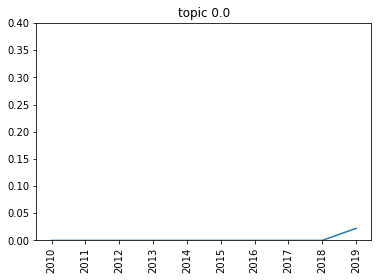

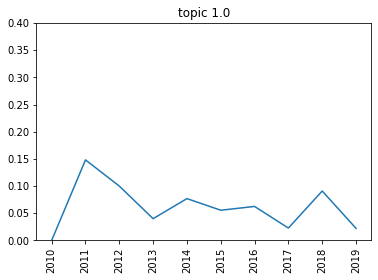

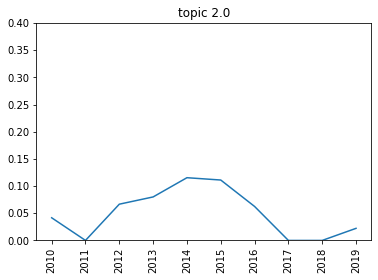

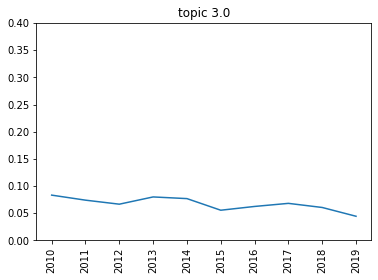

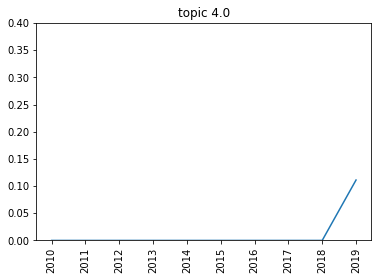

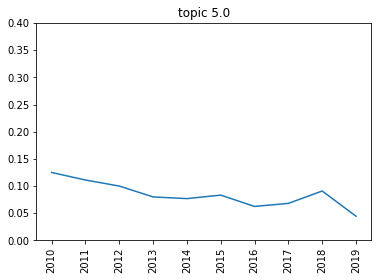

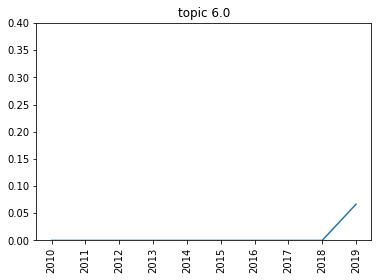

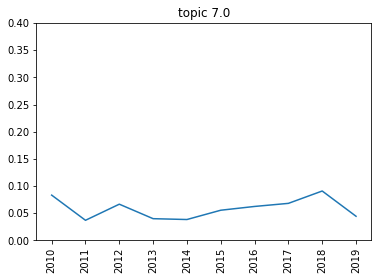

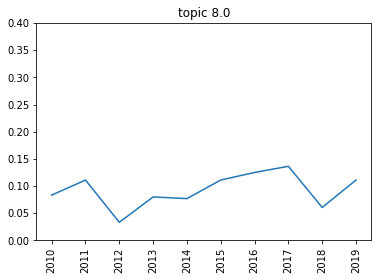

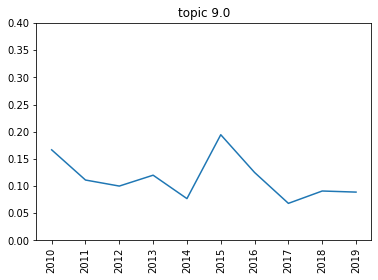

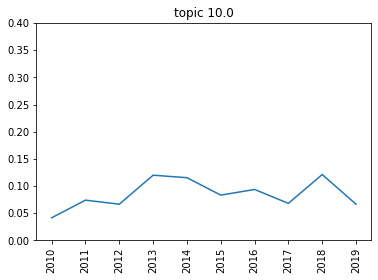

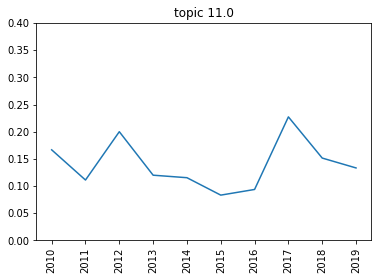

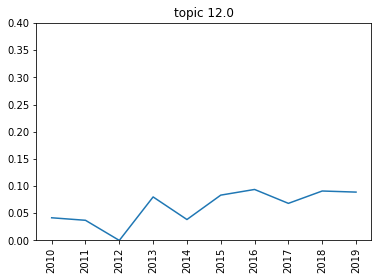

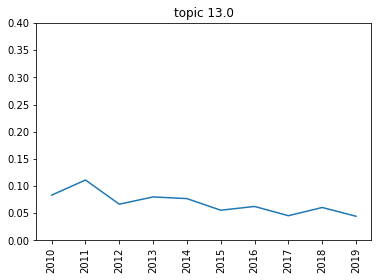

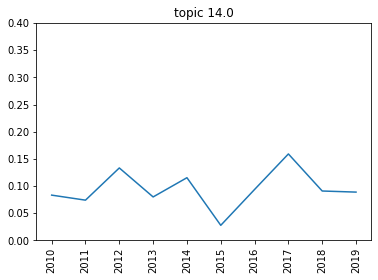

In [20]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))